In [ ]:
!pip install -qq arff2pandas
!pip install -q -U watermark
!pip install -qq -U pandas

!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
!unzip -qq ECG5000.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 90.8MB/s]
replace ECG5000.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
from torch import nn, optim
import copy

base_dir = '/content/drive/MyDrive/Colab Notebooks/BacalavrThesis'
os.chdir(base_dir)

import sys
sys.path.insert(0, base_dir)

import library.dataset_load as datasets
import library.models as models
import library.metrics as metrics
import library.lam.ssa as ssa
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset, test_normal_dataset, test_anomaly_dataset, seq_len, n_features = datasets.load_ECG_dataset()

Модель LSTM


In [ ]:
def train_model_LSTM(model, train_dataset, val_dataset, n_epochs, lr=1e-3):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history




In [ ]:
model = models.RecurrentAutoencoder_LSTM(seq_len, n_features, 32)
model = model.to(device)

In [ ]:
model, history = train_model_LSTM(
  model, 
  train_dataset[:300], 
  val_dataset[:50], 
  n_epochs=1,
  lr = 1e-3
)

Epoch 1: train loss 82.67925198872884 val loss 67.23429527282715


In [ ]:
metrics.norm_model(model, val_dataset)

In [ ]:
metrics.number_parameters(model)

63297

SSA


In [ ]:
model = ssa.SSA(10, 30)

In [ ]:
metrics.norm_model(model, val_dataset)

In [ ]:
for seq_true in val_dataset:
  seq0 = model(seq_true)
  break

In [ ]:
len(val_dataset[0])

140

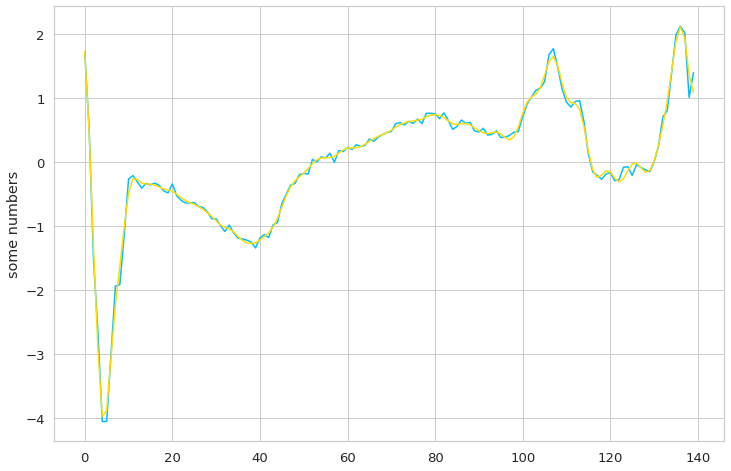

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_dataset[20])
seq0 = model(val_dataset[20])
with torch.no_grad():
  plt.plot(seq0)
plt.ylabel('some numbers')
plt.show()

S4


In [ ]:
import library.s4 as s4

In [ ]:
model = s4.Network_S4()

In [ ]:
model, history = train_model_LSTM(
  model, 
  train_dataset[:300], 
  val_dataset[:50], 
  n_epochs=1,
  lr = 1e-10
)